# 2. Model Train

## Model Ensemble

In [2]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)

In [3]:
def get_ensemble(models, input_shape, weights=None):
    x = tf.keras.layers.Input(shape=input_shape)
    if weights is None:
        weights = [np.ones((1, 5)) / len(models) for _ in range(len(models))]

    y = [model(x) * w for model, w in zip(models, weights)]
    y = tf.reduce_sum(y, axis=0)
    model = tf.keras.Model(inputs=x, outputs=y)
    return model


def get_data():

    noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        dtype=np.float32
    )

    train_generator = noaug_datagen.flow_from_directory(
        "../dataset/train/",
        class_mode="categorical",
        target_size=(224, 224),
        shuffle=False,
    )

    valid_generator = noaug_datagen.flow_from_directory(
        "../dataset/val/",
        class_mode="categorical",
        target_size=(224, 224),
        shuffle=False,
    )

    test_generator = noaug_datagen.flow_from_directory(
        "../dataset/test/",
        class_mode="categorical",
        target_size=(224, 224),
        shuffle=False,
    )

    return train_generator, valid_generator, test_generator


def get_metrics(model, data, name=None, show_results=True):
    if name is None:
        name = model.name

    y_true = data.labels
    y_pred = np.argmax(model.predict(data), axis=1)

    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    accuracies = np.diag(cm)

    for i, a in enumerate(accuracies):
        report[str(i)]["accuracy"] = a

    if show_results:
        np.set_printoptions(precision=2)
        print(f"Accuracy Score - {name}: {acc}")
        print(f"Balanced Accuracy Score - {name}: {bal_acc}")
        print("\n")
        print(classification_report(y_true, y_pred))
        print("Confusion matrix:")
        print(cm)
        print("Classes accuracies", accuracies)
        np.set_printoptions(precision=None)

    return report


def compute_confusion_matrix(
    model,
    class_names,
    data,
    name=None,
):
    y_true = data.labels
    y_pred = np.argmax(model.predict(data), axis=1)

    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)


def embed_preproc(model, preproc, input_shape):
    return tf.keras.models.Sequential(
        [
            tf.keras.layers.Lambda(preproc, input_shape=input_shape),
            tf.keras.models.load_model(model),
        ]
    )


def load_models(models, input_shape):
    return [
        embed_preproc(model, preproc, input_shape) for model, preproc in models
    ]

In [4]:
class_names = ["Healthy", "Doubtful", "Minimal", "Moderate", "Severe"]
model_name = "Ensemble"

# get generators
train, valid, test = get_data()
input_shape = 224, 224, 3

# load models
models = [
    [
        "models/model_ResNet50_ft.hdf5",
        tf.keras.applications.resnet50.preprocess_input,
    ],
    [
        "models/model_Xception_ft.hdf5",
        tf.keras.applications.xception.preprocess_input,
    ],
    [
        "models/model_Inception_ResNet_V2_ft.hdf5",
        tf.keras.applications.inception_resnet_v2.preprocess_input,
    ],
]

models = load_models(models, input_shape)

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.
Found 1656 images belonging to 5 classes.
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-11 21:48:06.059510: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-11 21:48:06.059964: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# model weights
def get_ensemble_weights(models, metric):
    metrics = []
    for model in models:
        report = get_metrics(model, data=train, show_results=False)
        metrics.append([report[str(i)][metric] for i in range(5)])

    metrics = np.array(metrics)
    model_weights = metrics / np.sum(metrics, axis=0)
    return model_weights

In [6]:
# ensemble of models
ensemble_mean = get_ensemble(
    models,
    input_shape=(224, 224, 3),
)

ensemble_acc = get_ensemble(
    models,
    input_shape=(224, 224, 3),
    weights=get_ensemble_weights(models, "accuracy"),
)

ensemble_f1 = get_ensemble(
    models,
    input_shape=(224, 224, 3),
    weights=get_ensemble_weights(models, "f1-score"),
)

2023-01-11 21:48:18.729694: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-11 21:48:18.926676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


181/181 [==============================] - 28s 140ms/step


2023-01-11 21:48:46.935663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


181/181 [==============================] - 43s 229ms/step


2023-01-11 21:49:30.231278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


181/181 [==============================] - 38s 210ms/step


In [7]:
ensemble_mean.save("models/ensemble_mean.h5")
ensemble_acc.save("models/eemblensemble_acc.h5")
ensemble_f1.save("models/ens_f1.h5")

### Valid: ensemble_mean

2023-01-11 21:52:05.345689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 25s 784ms/step
Accuracy Score - ensemble_mean: 0.6416464891041163
Balanced Accuracy Score - ensemble_mean: 0.6863612346815292


              precision    recall  f1-score   support

           0       0.77      0.65      0.70       328
           1       0.34      0.44      0.39       153
           2       0.67      0.71      0.69       212
           3       0.78      0.71      0.74       106
           4       0.81      0.93      0.86        27

    accuracy                           0.64       826
   macro avg       0.67      0.69      0.68       826
weighted avg       0.67      0.64      0.65       826

Confusion matrix:
[[0.65 0.28 0.06 0.01 0.01]
 [0.32 0.44 0.22 0.02 0.  ]
 [0.06 0.17 0.71 0.06 0.  ]
 [0.01 0.03 0.22 0.71 0.04]
 [0.   0.   0.   0.07 0.93]]
Classes accuracies [0.65 0.44 0.71 0.71 0.93]
26/26 [==============================] - 16s 611ms/step


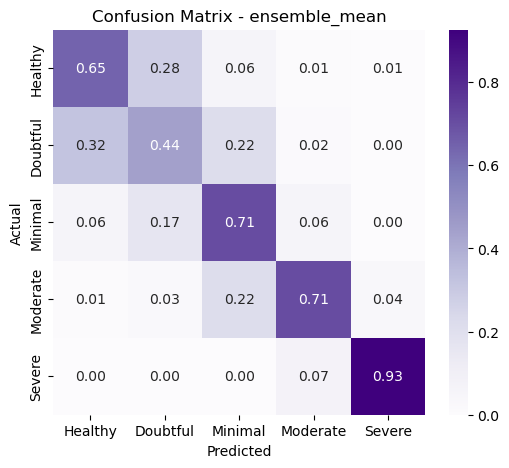

In [8]:
get_metrics(ensemble_mean, data=valid, name="ensemble_mean")
compute_confusion_matrix(
    ensemble_mean, class_names, data=valid, name="ensemble_mean"
)

### Valid: ensemble_acc

2023-01-11 21:52:47.233188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 32s 934ms/step
Accuracy Score - ensemble_acc: 0.6428571428571429
Balanced Accuracy Score - ensemble_acc: 0.6848485372571077


              precision    recall  f1-score   support

           0       0.77      0.66      0.71       328
           1       0.34      0.42      0.37       153
           2       0.66      0.72      0.69       212
           3       0.79      0.71      0.75       106
           4       0.78      0.93      0.85        27

    accuracy                           0.64       826
   macro avg       0.67      0.68      0.67       826
weighted avg       0.66      0.64      0.65       826

Confusion matrix:
[[0.66 0.27 0.06 0.01 0.01]
 [0.32 0.42 0.24 0.02 0.01]
 [0.07 0.16 0.72 0.06 0.  ]
 [0.01 0.03 0.22 0.71 0.04]
 [0.   0.   0.   0.07 0.93]]
Classes accuracies [0.66 0.42 0.72 0.71 0.93]
26/26 [==============================] - 16s 592ms/step


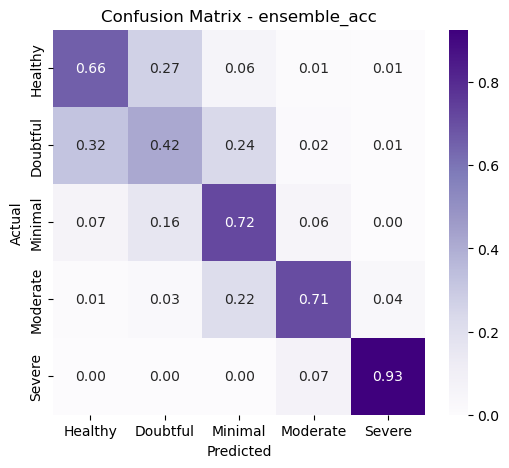

In [9]:
get_metrics(ensemble_acc, data=valid, name="ensemble_acc")
compute_confusion_matrix(
    ensemble_acc, class_names, data=valid, name="ensemble_acc"
)

### Valid: ensemble_f1

2023-01-11 21:53:34.661126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 37s 1s/step
Accuracy Score - ensemble_f1: 0.6428571428571429
Balanced Accuracy Score - ensemble_f1: 0.6869709907790902


              precision    recall  f1-score   support

           0       0.77      0.65      0.70       328
           1       0.34      0.44      0.39       153
           2       0.67      0.71      0.69       212
           3       0.79      0.71      0.75       106
           4       0.83      0.93      0.88        27

    accuracy                           0.64       826
   macro avg       0.68      0.69      0.68       826
weighted avg       0.67      0.64      0.65       826

Confusion matrix:
[[0.65 0.28 0.06 0.01 0.  ]
 [0.33 0.44 0.21 0.02 0.  ]
 [0.06 0.17 0.71 0.06 0.  ]
 [0.01 0.03 0.22 0.71 0.04]
 [0.   0.   0.   0.07 0.93]]
Classes accuracies [0.65 0.44 0.71 0.71 0.93]
26/26 [==============================] - 17s 645ms/step


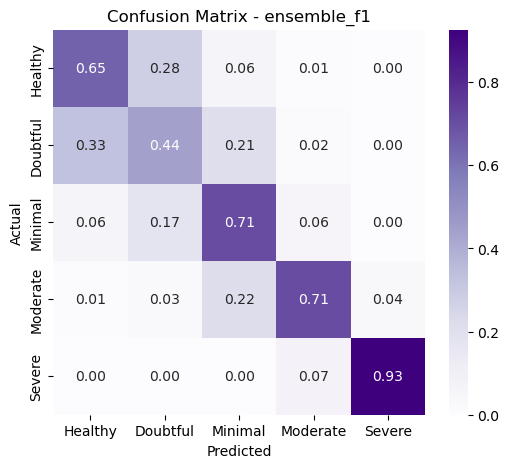

In [10]:
get_metrics(ensemble_f1, data=valid, name="ensemble_f1")
compute_confusion_matrix(
    ensemble_f1, class_names, data=valid, name="ensemble_f1"
)

### Results

| Model | Balanced Accuracy Score |
| ------| ----------------------- | 
| ensemble_mean | 68.63% | 
| ensemble_acc | 68.48% | 
| ensemble_f1 | 68.69% | 

### Test

Best result: `ensemble_f1` $68.68\%$

52/52 [==============================] - 37s 708ms/step
Accuracy Score - ensemble_f1: 0.6871980676328503
Balanced Accuracy Score - ensemble_f1: 0.7143286019795385


              precision    recall  f1-score   support

           0       0.82      0.73      0.77       639
           1       0.36      0.43      0.39       296
           2       0.69      0.73      0.71       447
           3       0.86      0.79      0.82       223
           4       0.73      0.90      0.81        51

    accuracy                           0.69      1656
   macro avg       0.69      0.71      0.70      1656
weighted avg       0.71      0.69      0.69      1656

Confusion matrix:
[[0.73 0.22 0.05 0.   0.  ]
 [0.28 0.43 0.28 0.01 0.  ]
 [0.04 0.18 0.73 0.04 0.01]
 [0.   0.04 0.13 0.79 0.04]
 [0.   0.   0.   0.1  0.9 ]]
Classes accuracies [0.73 0.43 0.73 0.79 0.9 ]
52/52 [==============================] - 31s 586ms/step


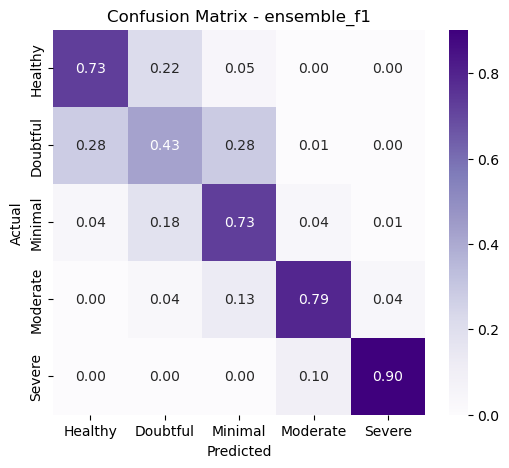

In [11]:
get_metrics(ensemble_f1, data=test, name="ensemble_f1")
compute_confusion_matrix(
    ensemble_f1, class_names, data=test, name="ensemble_f1"
)

#### Confusion matrix

In [13]:
y_true =test.labels
y_pred = np.argmax(ensemble_f1.predict(test), axis=1)

52/52 [==============================] - 30s 580ms/step


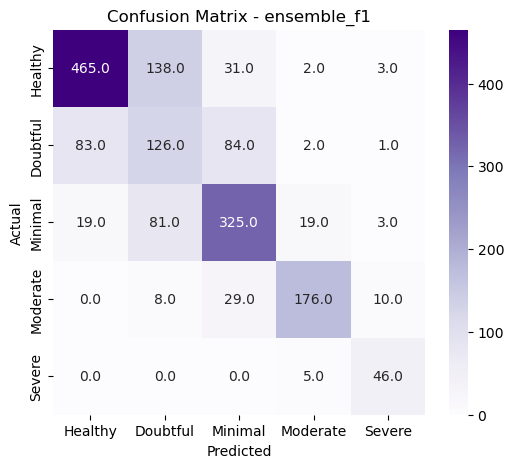

In [15]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

plt.subplots(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt=".1f",
    cmap="Purples",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.title(f"Confusion Matrix - ensemble_f1")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show(block=False)